### Test Data Processing

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

test_df = pd.read_csv('/Users/dylandietrich/DS4021-Final-Project/data/test.csv')

# drop unnecessary columns
test_df = test_df.drop(columns=['weather_temperature', 'weather_wind_mph', 'weather_humidity', 'weather_detail', 'stadium'])
test_df.head()

# first add total_score column
test_df['total_score'] = test_df['score_home'] + test_df['score_away']

# add column that represented current record for each team before each game of a season
# ensure games are sorted chronologically within each season
test_df["datetime"] = pd.to_datetime(test_df["schedule_date"])
test_df = test_df.sort_values(["schedule_season", "datetime"]).reset_index(drop=True)

# make output lists
home_records = []
away_records = []

# make dictionaries to track each team's W-L-T within the current season
team_wins = {}
team_losses = {}
team_ties = {}

current_season = None

for i, row in test_df.iterrows():
    season = row["schedule_season"]
    home = row["team_home"]
    away = row["team_away"]
    home_score = row["score_home"]
    away_score = row["score_away"]
   
    # new season, we reset all
    if season != current_season:
        team_wins = {}
        team_losses = {}
        team_ties = {}
        current_season = season

    # initialize teams for this season if needed
    for team in [home, away]:
        if team not in team_wins:
            team_wins[team] = 0
            team_losses[team] = 0
            team_ties[team] = 0

    # add current record before the game
    home_records.append(
        f"{team_wins[home]}-{team_losses[home]}-{team_ties[home]}"
    )
    away_records.append(
        f"{team_wins[away]}-{team_losses[away]}-{team_ties[away]}"
    )

    # update records after the game
    if home_score > away_score:
        team_wins[home] += 1
        team_losses[away] += 1
    elif away_score > home_score:
        team_wins[away] += 1
        team_losses[home] += 1
    else:
        # tie
        team_ties[home] += 1
        team_ties[away] += 1

# add results to dataframe
test_df["home_team_record"] = home_records
test_df["away_team_record"] = away_records

# make individual columns for wins, losses, and ties
test_df['home_wins'] = test_df['home_team_record'].apply(lambda x: int(x.split('-')[0]))
test_df['home_losses'] = test_df['home_team_record'].apply(lambda x: int(x.split('-')[1]))
test_df['home_ties'] = test_df['home_team_record'].apply(lambda x: int(x.split('-')[2]))
test_df['away_wins'] = test_df['away_team_record'].apply(lambda x: int(x.split('-')[0]))
test_df['away_losses'] = test_df['away_team_record'].apply(lambda x: int(x.split('-')[1]))
test_df['away_ties'] = test_df['away_team_record'].apply(lambda x: int(x.split('-')[2]))

# filter games that have already been recorded, no scheduled games
test_df = test_df[test_df["datetime"] <= "2025-11-04"]

# 1. Compute each team's average score per season
team_season_avg = (
    test_df.groupby(["team_home", "schedule_season"])["score_home"].mean().reset_index()
)
team_season_avg.columns = ["team", "season", "avg_score"]

# also include away team scoring
team_season_avg_away = (
    test_df.groupby(["team_away", "schedule_season"])["score_away"].mean().reset_index()
)
team_season_avg_away.columns = ["team", "season", "avg_score"]

# combine home + away scoring for a true team season average
team_season_avg = pd.concat([team_season_avg, team_season_avg_away])
team_season_avg = team_season_avg.groupby(["team", "season"])["avg_score"].mean().reset_index()

# 2. Shift averages to represent "previous season"
team_season_avg["prev_season"] = team_season_avg["season"] + 1

# this means: prev_season avg is used in the next year's games
team_prev = team_season_avg[["team", "prev_season", "avg_score"]]
team_prev.columns = ["team", "schedule_season", "prev_season_avg"]

# 3. Merge into main test_df
test_df = test_df.merge(
    team_prev,
    left_on=["team_home", "schedule_season"],
    right_on=["team", "schedule_season"],
    how="left"
)
test_df.rename(columns={"prev_season_avg": "home_prev_avg"}, inplace=True)
test_df = test_df.drop(columns=["team"])

test_df = test_df.merge(
    team_prev,
    left_on=["team_away", "schedule_season"],
    right_on=["team", "schedule_season"],
    how="left"
)
test_df.rename(columns={"prev_season_avg": "away_prev_avg"}, inplace=True)
test_df = test_df.drop(columns=["team"])

home = test_df[["schedule_season", "datetime", "team_home", "score_home", "score_away"]].rename(
    columns={"team_home": "team", "score_home": "points_scored", "score_away": "points_allowed"}
)

away = test_df[["schedule_season", "datetime", "team_away", "score_away", "score_home"]].rename(
    columns={"team_away": "team", "score_away": "points_scored", "score_home": "points_allowed"}
)

long_df = pd.concat([home, away])
long_df = long_df.sort_values(["team", "schedule_season", "datetime"]).reset_index(drop=True)

groups = long_df.groupby(["team", "schedule_season"])

long_df["rolling_scored"] = groups["points_scored"].transform(
    lambda s: s.shift().expanding().mean()
)

long_df["rolling_allowed"] = groups["points_allowed"].transform(
    lambda s: s.shift().expanding().mean()
)

test_df = test_df.merge(
    long_df[["team", "schedule_season", "datetime", "rolling_scored", "rolling_allowed"]],
    left_on=["team_home", "schedule_season", "datetime"],
    right_on=["team", "schedule_season", "datetime"],
    how="left"
).rename(
    columns={
        "rolling_scored": "home_rolling_scored",
        "rolling_allowed": "home_rolling_allowed"
    }
).drop(columns=["team"])


test_df = test_df.merge(
    long_df[["team", "schedule_season", "datetime", "rolling_scored", "rolling_allowed"]],
    left_on=["team_away", "schedule_season", "datetime"],
    right_on=["team", "schedule_season", "datetime"],
    how="left"
).rename(
    columns={
        "rolling_scored": "away_rolling_scored",
        "rolling_allowed": "away_rolling_allowed"
    }
).drop(columns=["team"])

# drop 2005 due to NaNs from prev season averages
test_df = test_df[test_df["schedule_season"] != 2005]


### Evaluation on Test Set

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [5]:
features = [
    "over_under_line",
    "stadium_neutral",
    "home_wins", "home_losses", "home_ties",
    "away_wins", "away_losses", "away_ties",
    "home_prev_avg", "away_prev_avg",
    "home_rolling_scored", "home_rolling_allowed",
    "away_rolling_scored", "away_rolling_allowed"
]

X_df = test_df[features]
X = test_df[features].to_numpy()
y = test_df["total_score"].to_numpy()

In [6]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # fills NaNs
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=100.0, solver='auto', random_state=123))
])

In [7]:
# fitting best model to the test data
pipeline.fit(X, y)
y_pred = pipeline.predict(X)

mse  = mean_squared_error(y, y_pred)
r2   = r2_score(y, y_pred)

print(f"Test MSE:  {mse:.4f}")
print(f"Test R2:   {r2:.4f}")

Test MSE:  186.7083
Test R2:   0.0763


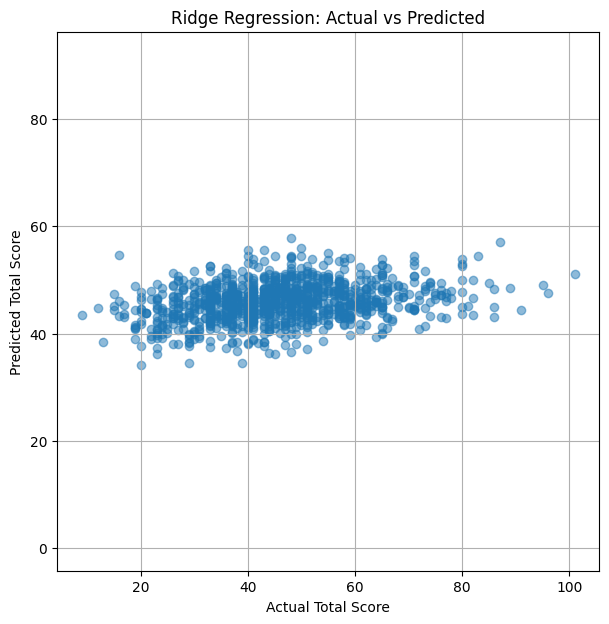

In [8]:
plt.figure(figsize=(7,7))
plt.scatter(y, y_pred, alpha=0.5)
plt.axis("equal")
plt.xlabel("Actual Total Score")
plt.ylabel("Predicted Total Score")
plt.title("Ridge Regression: Actual vs Predicted")
plt.grid(True)
plt.show()

Here we see that the R2 was slightly worse with test data than on the validation set from the training data. An R2 of 0.0763 indicates that the model is not a good fit on the data and that there is a lot of unexplained variation.